In [2]:
#import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.stats import zscore
import sklearn
from sklearn.model_selection import train_test_split
import fnmatch

In [3]:
#functions for finding and reading data files

def find_files(directory, pattern='Data*.csv', withlabel=True):
    '''fine all the files in one directory and assign '1'/'0' to F or N files'''
    files = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            if withlabel:
                if 'non-seizure' in filename:
                    label = '0'
                else:
                    label = '1'
                files.append((os.path.join(root, filename), label))
            else:  # only get names
                files.append(os.path.join(root, filename))
    
    return files

def read_data(filename, header=None, ifnorm=False):
    '''read data from .csv
    Param:
        filename: string e.g. 'data/Data_F_Ind0001.csv'
        ifnorm: boolean, 1 zscore normalization
        start: with filter augmented data, start index of the column indicate which group of data to use
        width: how many columns of data to use, times of 2
    return:
        data: 2d array [seq_len, channel]'''

    data = pd.read_csv(filename, header=header, nrows=None)
    data = data.values  ### get data without row_index
    if ifnorm:   ### 2 * 10240  normalize the data into [0.0, 1.0]]
        data_norm = zscore(data)
        data = data_norm
    #data = np.squeeze(data)   ## shape from [1, seq_len] --> [seq_len,]
    return data


In [4]:
#find segmented files and return them with label
seg_files_wlabel = find_files('C:\\Users\\hien\\Desktop\\eeg_data\\seg_data', pattern='seg*.csv', withlabel=True)

print("first file with label:", seg_files_wlabel[0])

first file with label: ('C:\\Users\\hien\\Desktop\\eeg_data\\seg_data\\segNorm_read_out_annosep09_anno_115_non-seizure_No0.csv', '0')


In [5]:
#plt.plot(np.array(signals[0]))

In [47]:
#split files and labels

files, labels = np.array(seg_files_wlabel)[:, 0].astype(np.str), np.array(np.array(seg_files_wlabel)[:, 1]).astype(np.int)


In [48]:
#number of elements in files/labels
len(labels)

540

In [49]:
#split data into training and testing

files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=0.4, random_state=42)

#print(labels_train)
print("number of test input:", len(labels_test))
print("number of training input:", len(labels_train))


number of test input: 216
number of training input: 324


In [50]:
#set parameters

learning_rate = 0.0001
total_epochs = 20 #number of iterations over all samples / epoch
batch_size = 64 #amount of files fed to model per iteration
test_sample = len(labels_test)
total_batches = len(labels_train)//batch_size
num_classes = 2

chunk_size = 8
n_chunks = 2048//chunk_size
rnn_size = 64

tf.reset_default_graph()


In [51]:
#set variables x=input, y_=output, W=weights, b=bias

# Placeholder variable for the input images
x = tf.placeholder("float",[None, n_chunks, chunk_size], name = "x") #number of data points

#transpose
x_transp = tf.transpose(x, [1, 0, 2])

# Reshape it into [num_images, img_height, img_width, num_channels]
x_reshape = tf.reshape(x_transp, [-1, chunk_size]) #why reshape?

# split x
x_split = tf.split(x_reshape, n_chunks, 0)

# Placeholder variable for the true labels associated with the images
y_true = tf.placeholder("float",[None,2], name = "y_true") #2 possible outputs
y_true_cls = tf.argmax(y_true, axis=1) 


In [52]:
W = tf.Variable(tf.zeros([rnn_size, 2]), name = "W")
b = tf.Variable(tf.zeros([2]), name = "b")

In [53]:
#rnn setup 
#with tf.variable_scope('rnn', reuse=tf.AUTO_REUSE) as scope:


lstm_layer = tf.contrib.rnn.BasicLSTMCell(rnn_size)
outputs, states = tf.nn.static_rnn(lstm_layer, x_split, dtype = tf.float32)

output = tf.matmul(outputs[-1], W) + b

In [54]:
network_output = tf.argmax(output, axis=1) 

In [55]:
#define and minimze cost function

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y_true)
loss_op = tf.reduce_mean(cross_entropy)

In [56]:
#training

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_op) 

In [57]:
#Determining accuracy of parameters

correct_prediction = tf.equal(tf.argmax(output, axis=1), y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [58]:
#rearrange dataset

dataset_train = tf.data.Dataset.from_tensor_slices((files_train, labels_train)).repeat().batch(batch_size).shuffle(buffer_size=10000)
iter = dataset_train.make_initializable_iterator()
ele = iter.get_next()   #you get the filename

acc train 0.540625
acc train 0.553125
acc train 0.58125
acc train 0.5875
acc train 0.603125
acc train 0.615625
acc train 0.590625
acc train 0.628125
acc train 0.625
acc train 0.65
acc test [0.5324074  0.5462963  0.54166669 0.5462963  0.5462963  0.54166669
 0.5462963  0.55092591 0.56481481 0.56481481 0.57407409 0.57407409
 0.5787037  0.60185188 0.59722221 0.59722221 0.6111111  0.625
 0.63425928 0.64814812]


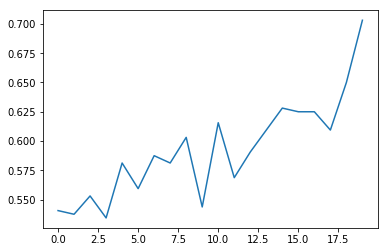

In [59]:
#run session and plot train accuracy

with tf.Session() as sess:
    sess.run(iter.initializer)
    sess.run(tf.global_variables_initializer())
    
    acc_epoch = np.zeros((total_epochs)) 
    acc_epoch_test = np.zeros((total_epochs)) 
    
    for epoch in range(total_epochs):
        acc_batch = 0
        acc_batch_test = 0
        avg_cost = 0
    
        for batch in range(total_batches):
            files_train, labels_train =  sess.run(ele)   # names, 1s/0s the filename is bytes object!!! TOD
            
            data_train = np.zeros([batch_size, 2048, 1])
            files_train = files_train.astype(np.str)
            
            for ind in range(batch_size):
                #print(files_train)
                data = read_data(files_train[ind],  header=None, ifnorm=True)
                data_train[ind, :] = data
            
            labels_train_hot =  np.eye((num_classes))[labels_train.astype(int)] # get one-hot lable
            
            acc, _, pred, loss = sess.run([accuracy, optimizer, correct_prediction, loss_op], feed_dict={x: data_train.reshape(-1, n_chunks, chunk_size), y_true: labels_train_hot})
        
        
            acc_batch += acc 
    
        acc_epoch[epoch] = acc_batch / total_batches
        avg_cost += loss / total_batches
        if epoch % 2 == 0:
            print("acc train", acc_batch / total_batches)
        
        data_test = np.zeros([test_sample, 2048, 1])
        for test_nr in range(test_sample):
            
            files_test = files_test.astype(np.str)
                
            data_test_01 = read_data(files_test[test_nr],  header=None, ifnorm=True)
            data_test[test_nr, :] = data_test_01
            
        labels_test_hot = np.eye((num_classes))[labels_test.astype(int)]
        
        acc_test, pred_test, pred_labels = sess.run([accuracy, correct_prediction, network_output], feed_dict={x: data_test.reshape(-1, n_chunks, chunk_size), y_true: labels_test_hot})
        
        #acc_batch_test += acc_test 
    
        acc_epoch_test[epoch] = acc_test 
    print("acc test", acc_epoch_test)
        
        
        
            

            
plt.plot(np.array(acc_epoch))   


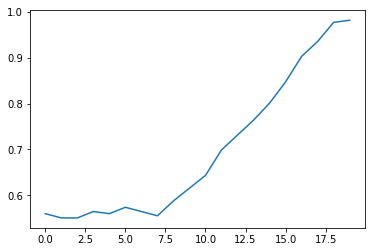

In [19]:
plt.plot(np.array(acc_epoch_test))  

In [20]:
avg_cost

0.12538410425186158

In [21]:
#pred_test

In [22]:
#pred

In [23]:
sklearn.metrics.confusion_matrix(labels_test, pred_labels, labels=None, sample_weight=None)

array([[112,   3],
       [  1, 100]], dtype=int64)

In [24]:
labels_test

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [25]:
pred_labels

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int64)

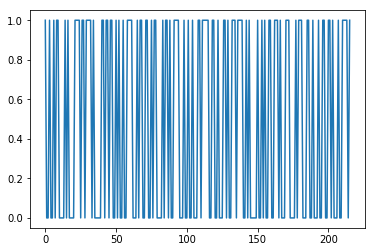

In [26]:
plt.plot(pred_labels)